In [1]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import random
print("Yokoso, watashi no Knapsack Projecto...")

Yokoso, watashi no Knapsack Projecto...


In [3]:
class Item():
    profit = 0
    weight = 0
    def __init__(self, profit, weight):
        self.weight = weight
        self.profit = profit
    def setProfit(self,p):
        self.profit=p
    def setWeight(self,w):
        self.weight = w
    def show_item(self):
        print("Profit: ",self.profit," Weight: ",self.weight)

class Knapsack():
    capacity = 0
    nbItems = 0
    items = []
    def setNbItems(self,nb):
        self.nbItems = nb
    def setCapacity(self,cap):
        self.capacity = cap
    def addItem(self,profit, weight):
        self.items.append(Item(profit,weight)) 
    


In [4]:
# Read the data
def read_data(filename):
    f = open(filename, "r")
    lines = f.readlines()
    knapsack = Knapsack()
    nbItemLine = lines[3].strip().split()
    knapsack.setNbItems(int(nbItemLine[1]))
    capacityLine = lines[4].strip().split()
    knapsack.setCapacity(int(capacityLine[1]))
    data = lines[7:]
    for line in data:
        values = line.strip().split()
        knapsack.addItem(int(values[1]), int(values[2]))
    f.close()
    return knapsack

knapsack_instance = read_data("Data/pi-12-10000-1000-001.kna")
        
for elem in knapsack_instance.items:
        elem.show_item()

print("Nb Items: ", knapsack_instance.nbItems)
print("Capacity: ", knapsack_instance.capacity)

Profit:  582  Weight:  582
Profit:  194  Weight:  194
Profit:  679  Weight:  679
Profit:  485  Weight:  485
Profit:  312  Weight:  396
Profit:  873  Weight:  873
Profit:  468  Weight:  594
Profit:  208  Weight:  264
Profit:  364  Weight:  462
Profit:  260  Weight:  330
Profit:  582  Weight:  582
Profit:  388  Weight:  388
Profit:  291  Weight:  291
Profit:  104  Weight:  132
Profit:  520  Weight:  660
Profit:  416  Weight:  528
Profit:  970  Weight:  970
Profit:  260  Weight:  330
Profit:  582  Weight:  582
Profit:  364  Weight:  462
Profit:  776  Weight:  776
Profit:  194  Weight:  194
Profit:  468  Weight:  594
Profit:  970  Weight:  970
Profit:  312  Weight:  396
Profit:  260  Weight:  330
Profit:  156  Weight:  198
Profit:  485  Weight:  485
Profit:  416  Weight:  528
Profit:  364  Weight:  462
Profit:  582  Weight:  582
Profit:  388  Weight:  388
Profit:  468  Weight:  594
Profit:  679  Weight:  679
Profit:  52  Weight:  66
Profit:  156  Weight:  198
Profit:  312  Weight:  396
Pro

In [5]:
def EstSolutionValide(solution,SacADos):
    # Fonctions pour checker si une solution est valide ou non
    capacity = SacADos.capacity
    total_capacity = 0
    for i in range(SacADos.nbItems):
        total_capacity+=solution[i]*SacADos.items[i].weight
        if(total_capacity>capacity):
            return False
    return True
def reparer_solution(solution, SacADos):
    # Fonctions pour réparer une solution en enlever aléatoirement des items
    capacity = SacADos.capacity
    total_capacity = sum(solution[i] * SacADos.items[i].weight for i in range(SacADos.nbItems))
    while total_capacity > capacity:
        selected_indices = [i for i, x in enumerate(solution) if x == 1]
        remove_index = random.choice(selected_indices)
        solution[remove_index] = 0
        total_capacity = sum(solution[i] * SacADos.items[i].weight for i in range(SacADos.nbItems))
    return solution
def calculer_solution(solution,SAD):
    # Fonction pour calculer une solution
    return sum(solution[i] * SAD.items[i].profit for i in range(SAD.nbItems))
def calculer_fitness(solutions,SAD):
    # Fonction pour retourner un tableau de fitness des solutions
    return [calculer_solution(sol,SAD) for sol in solutions]
def select_best_solution(solutions, fitness, n_best=1):
    # Fonction pour séléctioner les meilleurs solutions
    solutions_with_fitness = list(zip(solutions, fitness))
    solutions_with_fitness.sort(key=lambda x: x[1], reverse=True)
    best_solutions = [sol for sol, fit in solutions_with_fitness[:n_best]]
    return best_solutions


In [6]:
def selection_roulette_nfois(solutions,fitness,n):
    # Fonctions pour selections de n nouvelles solutions par tournant n fois la roulette
    total_fitness = sum(fitness)
    selected = []
    for _ in range(n):
        random_fitness = random.uniform(0,total_fitness)
        somme_fitness = 0
        for i,f in enumerate(fitness):
            somme_fitness+=f
            if somme_fitness>= random_fitness:
                selected.append(solutions[i])
                break
    return selected
def selection_roulette_1fois(solutions,fitness,n):
    # Fonctions pour selections de n nouvelles solutions par tournant 1 fois la roulette
    totalfitness = sum(fitness)
    selected = []
    step = totalfitness/n
    start = random.uniform(0, step)
    pointers = [start + i * step for i in range(n)]
    somme_fitness = 0
    index = 0
    for ptr in pointers:
        while somme_fitness < ptr:
            somme_fitness += fitness[index]
            index += 1
        selected.append(solutions[index - 1])
    return selected
def creation_population_initale(SAD,n):
    Nsol = []
    proba_0 = 0.5 # Probabilité de génération de zero
    for i in range(n):
        sol = np.random.choice([0, 1], size=SAD.nbItems, p=[proba_0, 1-proba_0])
        if not EstSolutionValide(sol, SAD):
            sol = reparer_solution(sol, SAD)
        Nsol.append(sol)
    return Nsol
def croisement_simple(solutions,SAD):
    enfants = []
    for i in range(0, len(solutions), 2):  # Parcours par paires
        if i + 1 < len(solutions):  # Vérifie qu'il y a une paire
            parent1 = solutions[i]
            parent2 = solutions[i + 1]
            milieu = len(parent1) // 2  # Point de croisement au milieu
            # Enfant 1 : première moitié de parent1 + deuxième moitié de parent2
            enfant1 = np.concatenate((parent1[:milieu], parent2[milieu:]))
            # Enfant 2 : première moitié de parent2 + deuxième moitié de parent1
            enfant2 = np.concatenate((parent2[:milieu], parent1[milieu:]))
            enfants.extend([enfant1, enfant2])
    return enfants
def mutation(solutions):
    if random.randint(1, 100) == 1:  # Probabilité de 1/1000
        # Sélectionne une solution au hasard
        index_solution = random.randint(0, len(solutions) - 1)
        solution = solutions[index_solution]
        
        # Sélectionne un élément aléatoire à muter
        index_element = random.randint(0, len(solution) - 1)
        
        # Applique la mutation (inverse la valeur : 0 -> 1 ou 1 -> 0)
        solution[index_element] = 1 - solution[index_element]
        
        # print(f"Mutation appliquée à la solution {index_solution}, élément {index_element}")
    return solutions


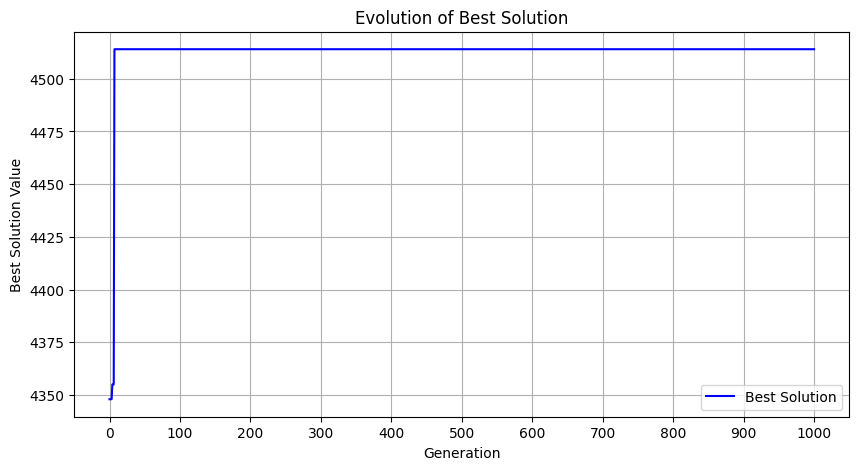

4514


In [8]:
import numpy as np
import matplotlib.pyplot as plt

SAD = read_data("Data/pi-12-1000-1000-001.kna")
n = (SAD.nbItems // 20) 
if n%2==0:
    n+=1
Nsol = creation_population_initale(SAD, n)
fitness = calculer_fitness(Nsol, SAD)
bestKnown = select_best_solution(Nsol, fitness)
generations = [0]
best_solutions = []
tempBestSol = []

best_G0 = calculer_solution(bestKnown[0], SAD)
best_solutions.append(best_G0)

for gen in range(1000):
    fitness = calculer_fitness(Nsol, SAD)
    bestKnown = select_best_solution(Nsol, fitness)
    tempBestSol = []
    
    best_solution = calculer_solution(bestKnown[0], SAD)
    generations.append(gen + 1)
    best_solutions.append(best_solution)
    
    Nsol = selection_roulette_1fois(Nsol, fitness, n)
    if len(Nsol) % 2 == 1:
        for i, arr in enumerate(Nsol):
            if np.array_equal(arr, bestKnown[0]):
                del Nsol[i] 
                break 
        tempBestSol = bestKnown[0]
    Nsol = croisement_simple(Nsol, SAD)
    Nsol = mutation(Nsol)
    
    if len(tempBestSol) != 0:
        Nsol.append(tempBestSol)
    
    for sol in Nsol:
        if not EstSolutionValide(sol, SAD):
            sol = reparer_solution(sol, SAD)
    fitness = calculer_fitness(Nsol, SAD)

plt.figure(figsize=(10, 5))
plt.plot(generations, best_solutions, linestyle='-', color='b', label="Best Solution")
plt.xlabel("Generation")
plt.ylabel("Best Solution Value")
plt.title("Evolution of Best Solution")
step_size = 100
plt.xticks(np.arange(0, max(generations) + 1, step_size))
plt.legend()
plt.grid()
plt.show()
print(max(best_solutions))


In [9]:
print(bestKnown[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [10]:
max(best_solutions)

np.int64(4514)

In [11]:
print(bestKnown[0])
print(calculer_solution(bestKnown[0],SAD))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 